In [1]:
import os
import re
import json
import utils
import random
import gensim
import warnings

import numpy as np
import pandas as pd

from tasks import *
from pprint import pprint
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from yellowbrick.cluster import KElbowVisualizer

warnings.filterwarnings('ignore')

/home/tanmay/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
complete_df = pd.read_csv("data/clean_df.csv")
complete_df.shape

(40152, 11)

In [3]:
complete_df.head(2)

,Unnamed: 0,Unnamed: 0.1,paper_id,title,authors,affiliations,abstract,text,bibliography,raw_authors,raw_bibliography
0,0,0,6f005a0677f24f697c1ec3ce065ec4144519e357,Antiviral Mechanisms of Human Defensins Introd...,"Sarah S Wilson, Mayim E Wiens, Jason G Smith","Sarah S Wilson (University of Washington, 1705...",Defensins are an effector component of the inn...,Defensins are one of the most abundant classes...,Direct inactivation of viruses by human granul...,"[{'first': 'Sarah', 'middle': ['S'], 'last': '...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Direct ..."
1,1,1,4994fa72322bbf19120592304d92629226948d8e,Rapid Identification of Malaria Vaccine Candid...,"V Villard, G W Agak, G Frank, A Jafarshad, C S...","V Villard, G W Agak, G Frank, A Jafarshad, C S...",To identify malaria antigens for vaccine devel...,Human Plasmodium falciparum (Pf) infection is ...,Identification of vaccine candidates against s...,"[{'first': 'V', 'middle': [], 'last': 'Villard...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Identif..."


In [4]:
complete_df.describe()

,Unnamed: 0,Unnamed: 0.1
count,40152.000000,40152.000000
mean,29705.053248,29705.053248
std,17183.494309,17183.494309
min,0.000000,0.000000
25%,14787.750000,14787.750000
50%,29717.000000,29717.000000
75%,44551.250000,44551.250000
max,59560.000000,59560.000000


In [5]:
# Keep only texts with minimal number of words 

complete_df = complete_df[complete_df['text'].apply(lambda x: len(re.findall(r"(?i)\b[a-z]+\b", x))) > 1000]                                         
complete_df.shape

(38265, 11)

In [6]:
# See random text

complete_df.reset_index(inplace = True, drop = True)
complete_df.iloc[42]['abstract'][:500]

'The molecular analysis of disease pathogenesis in cattle has been limited by the lack of availability of tools to analyze both host and pathogen responses. These limitations are disappearing with the advent of methodologies such as microarrays that facilitate rapid characterization of global gene expression at the level of individual cells and tissues. The present review focuses on the use of microarray technologies to investigate the functional pathogenomics of infectious disease in cattle. We '

In [7]:
frac_of_articles = 1
train_df  = complete_df.sample(frac = frac_of_articles, random_state = 42)
train_corpus = (list(utils.read_corpus(train_df, 'abstract'))) 

In [8]:
# Using distributed memory model

model = gensim.models.doc2vec.Doc2Vec(dm = 1, vector_size = 50, min_count = 10, dm_mean = 1, epochs = 20, seed = 42, workers = 6)
model.build_vocab(train_corpus)
model.train(train_corpus, total_examples = model.corpus_count, epochs = model.epochs)

In [9]:
list_of_tasks = [task_1, task_2, task_3, task_4, task_5, task_6, task_7, task_8, task_9]

In [10]:
abstract_vectors = model.docvecs.vectors_docs
array_of_tasks = [utils.get_doc_vector(task, model) for task in list_of_tasks]

In [11]:
train_df['abstract_vector'] = [vec for vec in abstract_vectors]

### Nearest Neigbors search

In [13]:
train_df = train_df[train_df['abstract'].apply(lambda x: len(re.findall(r"(?i)\b[a-z]+\b", x))) > 40]
train_df.shape

(37302, 12)

In [14]:
train_array = train_df['abstract_vector'].values.tolist()

In [15]:
ball_tree = NearestNeighbors(algorithm = 'ball_tree', leaf_size = 20).fit(train_array)

In [16]:
# Query for all tasks

distances, indices = ball_tree.kneighbors(array_of_tasks, n_neighbors = 3)

In [17]:
for i, info in enumerate(list_of_tasks):
    print("="*80, f"\n\nTask = {info[:100]}\n", )
    df =  train_df.iloc[indices[i]]
    abstracts = df['abstract']
    titles = df['title']
    dist = distances[i]
    for l in range(len(dist)):
        print(f" Text index = {indices[i][l]} \n Distance = {distances[i][l]} \n Title: {titles.iloc[l]} \n Abstract extract: {abstracts.iloc[l][:200]}\n\n")


Task = What is known about transmission, incubation, and environmental stability of COVID-19? What do we kn

 Text index = 30086 
 Distance = 5.472676729866679 
 Title: Cooperative virus propagation underlies COVID-19 transmission dynamics 
 Abstract extract: The global pandemic due to the emergence of a novel coronavirus is a threat to the future health of humanity. There remains an urgent need to understand its transmission characteristics and design eff


 Text index = 1385 
 Distance = 5.490649947021904 
 Title: Issues Concerning Survival of Viruses on Surfaces 
 Abstract extract: Viruses are the causative agents of an estimated 60% of human infections worldwide. The most common viral illnesses are produced by enteric and respiratory viruses. Transmission of these viruses from 


 Text index = 31166 
 Distance = 5.568644791041079 
 Title: A Review and Update on Waterborne Viral Diseases Associated with Swimming Pools 
 Abstract extract: Infectious agents, including bacteria, virus

### Clustering and visualisation

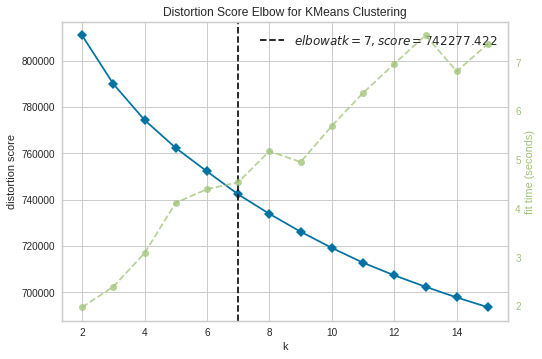

In [18]:
abstract_vectors = model.docvecs.vectors_docs
kmeans = KMeans(init = 'k-means++', max_iter = 300, random_state = 42) 
visualizer = KElbowVisualizer(kmeans, k = (2, 16))
visualizer.fit(abstract_vectors)
visualizer.show()

In [ ]:
# Clearly 7 clusters are here

In [ ]:
kmeans = KMeans(n_clusters = 7, init = 'k-means++', max_iter = 100, random_state = 42) 
train_df['labels'] = kmeans.fit_predict(train_array)

In [ ]:
train_df[['text','labels']][:20]

### Save Binaries

In [ ]:
model.save('models/CORD-doc2vec')

### Save KeyedVectors and prep Spacy Model

In [ ]:
model.wv.save_word2vec_format("data/word2vec.txt")